# Проект: классификация

In [472]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

Данные о клиентах банка:

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

Прочие признаки:

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [473]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [474]:
dupl_columns = list(df.columns)

mask = df.duplicated(subset=dupl_columns)
hotels_with_dupls = df[mask]
print(f'Число найденных дубликатов: {hotels_with_dupls.shape[0]}')

Число найденных дубликатов: 0


In [475]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

## Мы имеем 25 пропусков в столбце balance

---

In [476]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

## В столбце Job есть 70 неизвестных значений

---

In [477]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

def clear_balance(row):
    try:
        row = row.replace('$', '')
        row = row.replace(',', '.')
        row = row.replace(' ', '')
        row = row.strip()
        return float(row)
    except:
        return(float(row))

df['balance'] = df['balance'].apply(clear_balance)

### в столбце balance 774 значения с 0, и 1 значение -134.0 (возможно нужно будет убрать)

---

In [478]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [479]:
df['balance'].value_counts(ascending=False)

balance
 0.0       774
 1.0        39
 2.0        34
 3.0        34
 550.0      31
          ... 
 1641.0      1
 5517.0      1
 8332.0      1
 4859.0      1
-134.0       1
Name: count, Length: 3802, dtype: int64

In [480]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

---

* ### обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

In [481]:
def replace_unknown_with_mode(series):
    """
    Функция принимает объект pandas.Series и заменяет все вхождения 'unknown'
    на модальное значение в этом столбце.
    
    :param series: Объект pandas.Series, содержащий данные для обработки.
    :return: Объект pandas.Series с заменами.
    """
    # Проверяем, содержит ли серия значение 'unknown'
    if 'unknown' in series.unique():
        # Находим модальное значение
        mode = series.value_counts().index[0]
        # Заменяем 'unknown' на модальное значение
        return series.replace('unknown', mode)
    else:
        # Если 'unknown' отсутствует, возвращаем исходную серию
        return series

In [482]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df[['job', 'education']] = df[['job', 'education']].apply(replace_unknown_with_mode)

# Проверка на наличие пропусков
cols = ['job', 'education']

for col in cols:
    if 'unknown' in df[col].unique():
        print(f"Слово 'unknown' присутствует в столбце {col}.")
    else:
        print(f"Слово 'unknown' отсутствует в столбце {col}.")

Слово 'unknown' отсутствует в столбце job.
Слово 'unknown' отсутствует в столбце education.


### Задание:

    После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [483]:
# Выбираем клиентов с самой популярной работой и самым популярным уровнем образования
popular_job = df['job'].mode()[0]
popular_education = df['education'].mode()[0]

# Рассчитываем средний баланс для клиентов с самой популярной работой и уровнем образования
mean_balance_popular_job_education = df[(df['job'] == popular_job) & (df['education'] == popular_education)]['balance'].mean()

# Округляем ответ до трёх знаков после точки-разделителя
mean_balance_popular_job_education_rounded = round(mean_balance_popular_job_education, 3)

mean_balance_popular_job_education_rounded

1598.883

---

* ### Найдем выбросы balance через метод Тьюки

In [484]:
def outliers_iqr(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outlier_balance, cleaned_balance = outliers_iqr(df, 'balance')
print(f'Кол-во выбросов по стандартному методу Тюрки: {outlier_balance.shape[0]}')
print(f'Кол-во оставшихся по стандартному методу Тюрки: {cleaned_balance.shape[0]}')

Кол-во выбросов по стандартному методу Тюрки: 1057
Кол-во оставшихся по стандартному методу Тюрки: 10105


In [485]:
# удалите все выбросы для признака balance
df = df.drop(outlier_balance.index)

In [486]:
df.shape[0]

10105

## Часть 2:  Разведывательный анализ

---

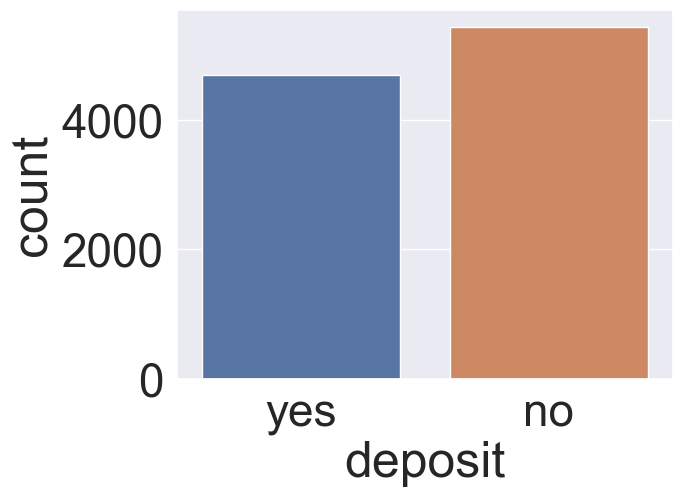

In [487]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.countplot(data=df, x='deposit');

### Мы видим, что данные сбалансированны, значит не нужно прибегать к методам борьбы с несбалансированностью данных.

In [488]:
# Сколько клиентов открыли депозит?
print(f"Кол-во отркрывших депозит: {df['deposit'].value_counts()['yes']}")

Кол-во отркрывших депозит: 4681


Начнём с описательных статистик для количественных переменных.

* Рассчитайте их и продумайте подробную интерпретацию.
* Попробуйте описать данные, которые у вас есть, увидеть первые зависимости.
* Рассмотрите минимальные и максимальные значения.
* Посмотрите на меры разброса и оцените, насколько данные вариативны.
* Сравнив меры центральной тенденции, сделайте выводы о том, есть ли аномальные значения с меньшей или большей стороны.
* Дополните выводы визуализациями. Вспомните, какие диаграммы могут помочь в иллюстрации распределений количественных данных.

In [489]:
types = df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

In [490]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)

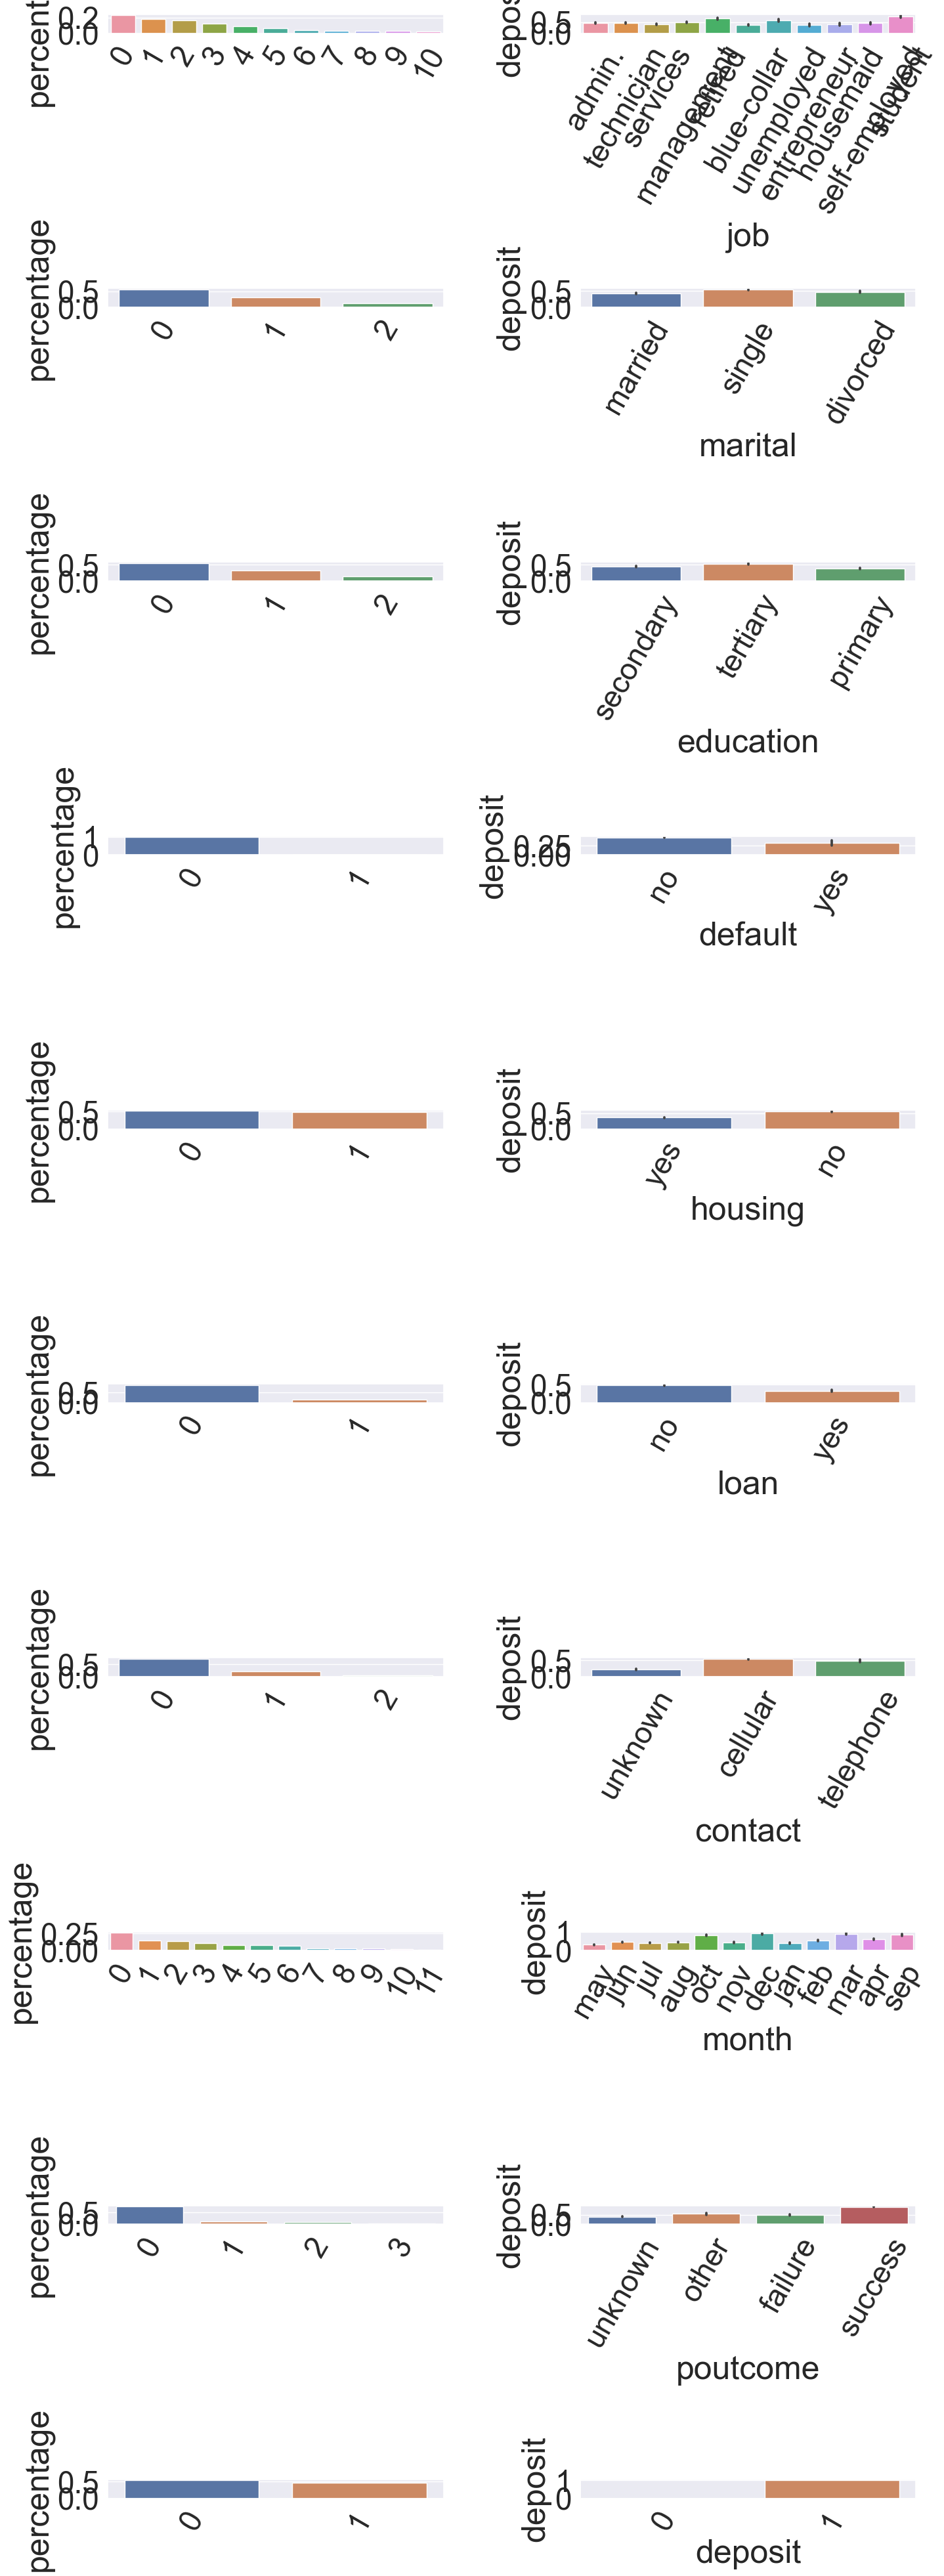

In [491]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x=count_data.index, y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей открыших депозит (среднее по столбцу deposit) в зависимости от категории
    mean_barplot = sns.barplot(data=df, x=feature, y='deposit', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

---
* ### рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат

### Категориальные признаки
1. default ввиду несбалансированности лучше удалить.
2. loan ввиду несбалансированности лучше удалить.
3. contact обработать или удалить (70% unknown)
4. poutcome обработать или удалить (75% unknown)

---

In [492]:
import dtale
d = dtale.show(df)
d

---
* ### рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

### Числовые признаки:
* balance распределенны почти нормально ((-2049)-(95-1227)-4063 $)
* age распределенны почти нормально (левостороннее смещение) (18 - (32-48) - 95)
* day - (1 - (8-22) - 31)
* duration нужно нормализовать, почти все значения слева (RobustScaler) (Распределение: 2-(137-490)-3881 сек)
* campaign нужно нормализовать, все значения слева (RobustScaler) (Распределение: 1-(1-3)-43 кол-во контактов)
* pdays нужно нормализовать, все значения слева (RobustScaler) (Распределение: (-1)-((-1)-2)-854)
* previous нужно нормализовать, все значения слева (RobustScaler) (Распределение: 0-(0-1)-58)

---

<Axes: xlabel='poutcome'>

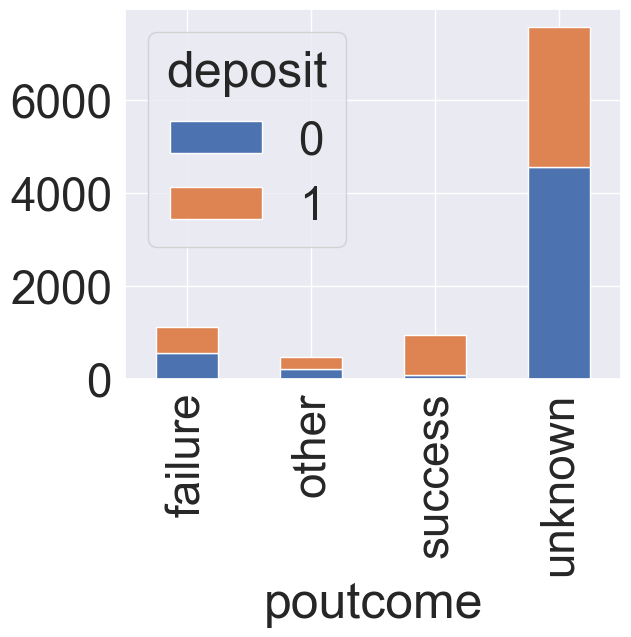

In [493]:
# Узнайте, для какого статуса маркетинговой кампании успех превалирует над количеством неудач. 
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

## Видно что при маркетинговой кампании success успех ввиде открытия депозита гораздо больше не открытия депозита.

---

<Axes: >

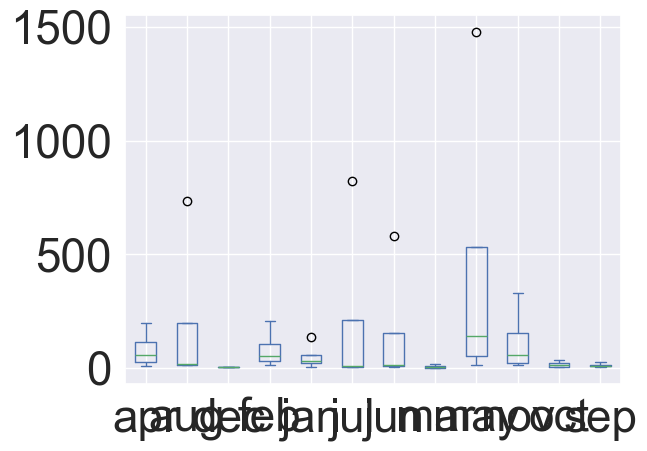

In [494]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
mask = df['deposit']==0

types = df[mask].groupby("poutcome")['month'].value_counts(normalize=False).unstack()
types.plot(kind='box', stacked='True')

### Рассмотрев все месяца, в которых отказывались от депозита, МАЙ является самым неблагоприятным для компании. 
* Возможно нужно будет добавить признак Мая в df, но сперва нужно выяснить почему в май - неподходящий месяц для таких акций.

---

Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

Создайте новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:
```
'<30';
'30-40';
'40-50';
'50-60';
'60+'.
```
Совет. После создания этой переменной постройте диаграмму (на ваш вкус), которая, с вашей точки зрения, сможет наилучшим образом отобразить различия в количестве открытых/не открытых депозитов для каждой возрастной группы.

In [495]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def make_age_group(data):
    if int(data) < 30:
        return '<30'
    elif 30 <= int(data) < 40:
        return '30-40'
    elif 40 <= int(data) < 50:
        return '40-50'
    elif 50 <= int(data) < 60:
        return '50-60'
    else: 
        return '60+'
df['age'] = df['age'].astype(str)
df['age'] = df['age'].apply(make_age_group)

<Axes: xlabel='age'>

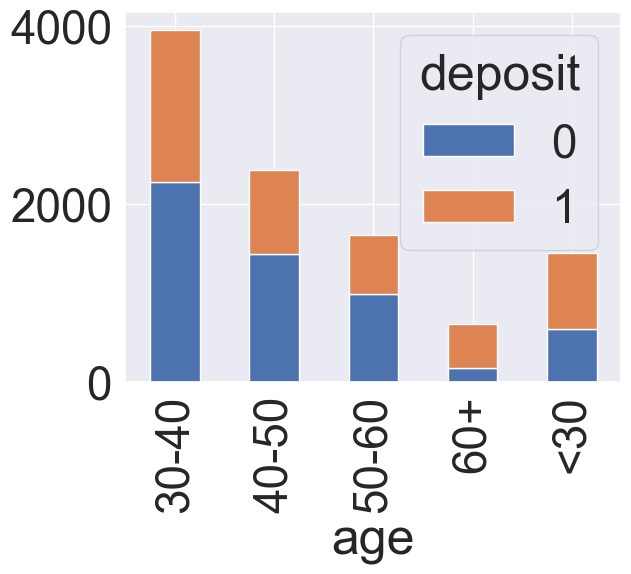

In [496]:
grouped_by_age = df.groupby("age")['deposit'].value_counts(normalize=False).unstack()
grouped_by_age.plot(kind='bar', stacked='True')

## Более склонны к открытию депозита склонны группы: '<30' и '60+'

---
## Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

* семейное положение;
* уровень образования;
* сфера занятости.

Постройте визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий предложенных выше трёх признаков. Постарайтесь оформить диаграммы максимально наглядно и описать полученный результат.

К каким категориям относится бόльшая часть людей? Среди каких групп населения есть тенденция соглашаться открывать депозит, а среди каких — отказываться?

<Axes: xlabel='marital'>

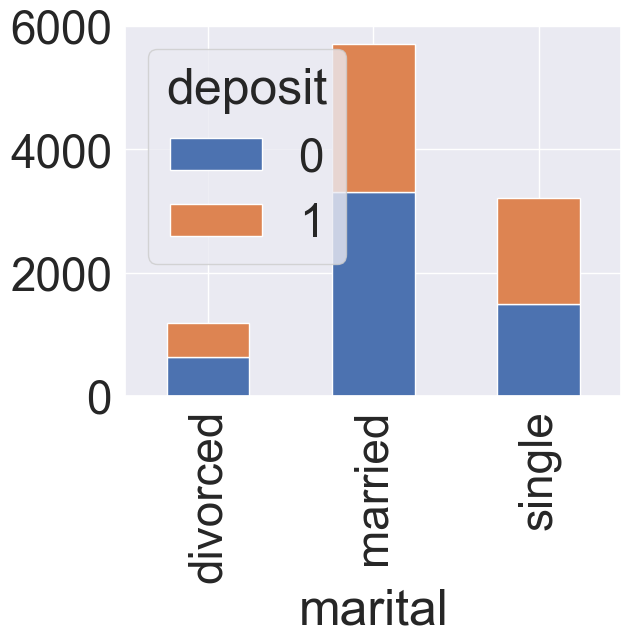

In [497]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
grouped_by_marital = df.groupby("marital")['deposit'].value_counts(normalize=False).unstack()
grouped_by_marital.plot(kind='bar', stacked='True')

## Если люди женаты или одиноки, то они более склонны к открытию депозита в отличие от разведенных

<Axes: xlabel='education'>

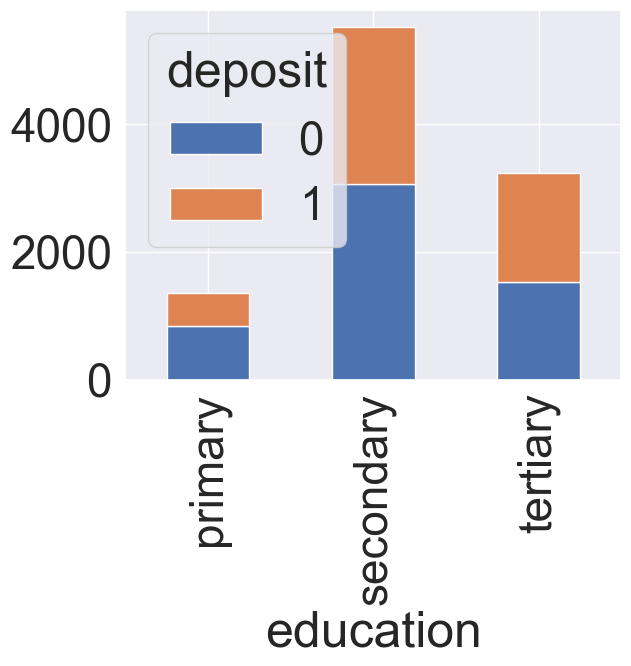

In [498]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
grouped_by_education = df.groupby("education")['deposit'].value_counts(normalize=False).unstack()
grouped_by_education.plot(kind='bar', stacked='True')

## Можно наблюдать тенденцию, что чем выше образование тем больше склонность к открытию депозита.

<Axes: xlabel='job'>

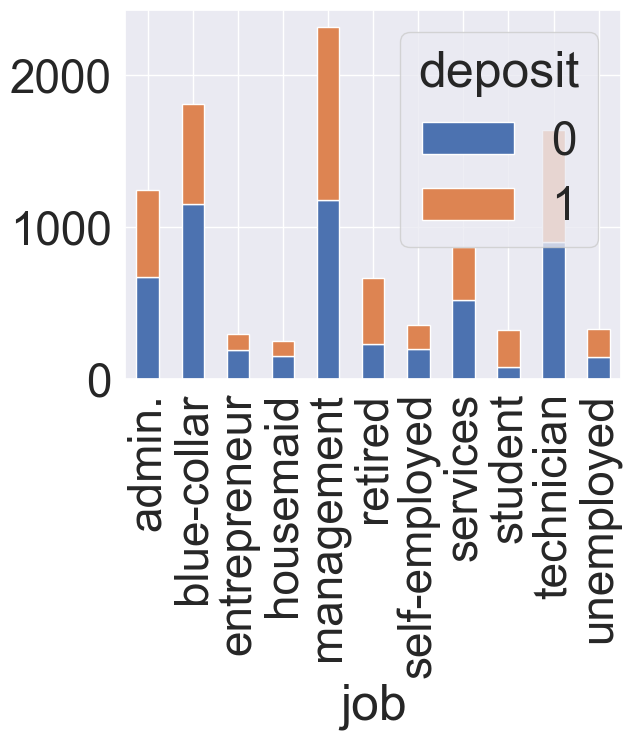

In [499]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
grouped_by_job = df.groupby("job")['deposit'].value_counts(normalize=False).unstack()
grouped_by_job.plot(kind='bar', stacked='True')

## Нет ярко выраженной разницы в виде деятельности человека, но например студенты, незанятые имею склонность к открытию депозита больше 50% 

---
### В предыдущих заданиях мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

* Разделите таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части постройте сводную диаграмму по уровню образования и семейному положению. Представьте результаты в виде тепловых карт. Различаются ли наиболее популярные группы для открывших депозит и для неоткрывших? Какой вывод вы можете сделать, исходя из полученных данных?

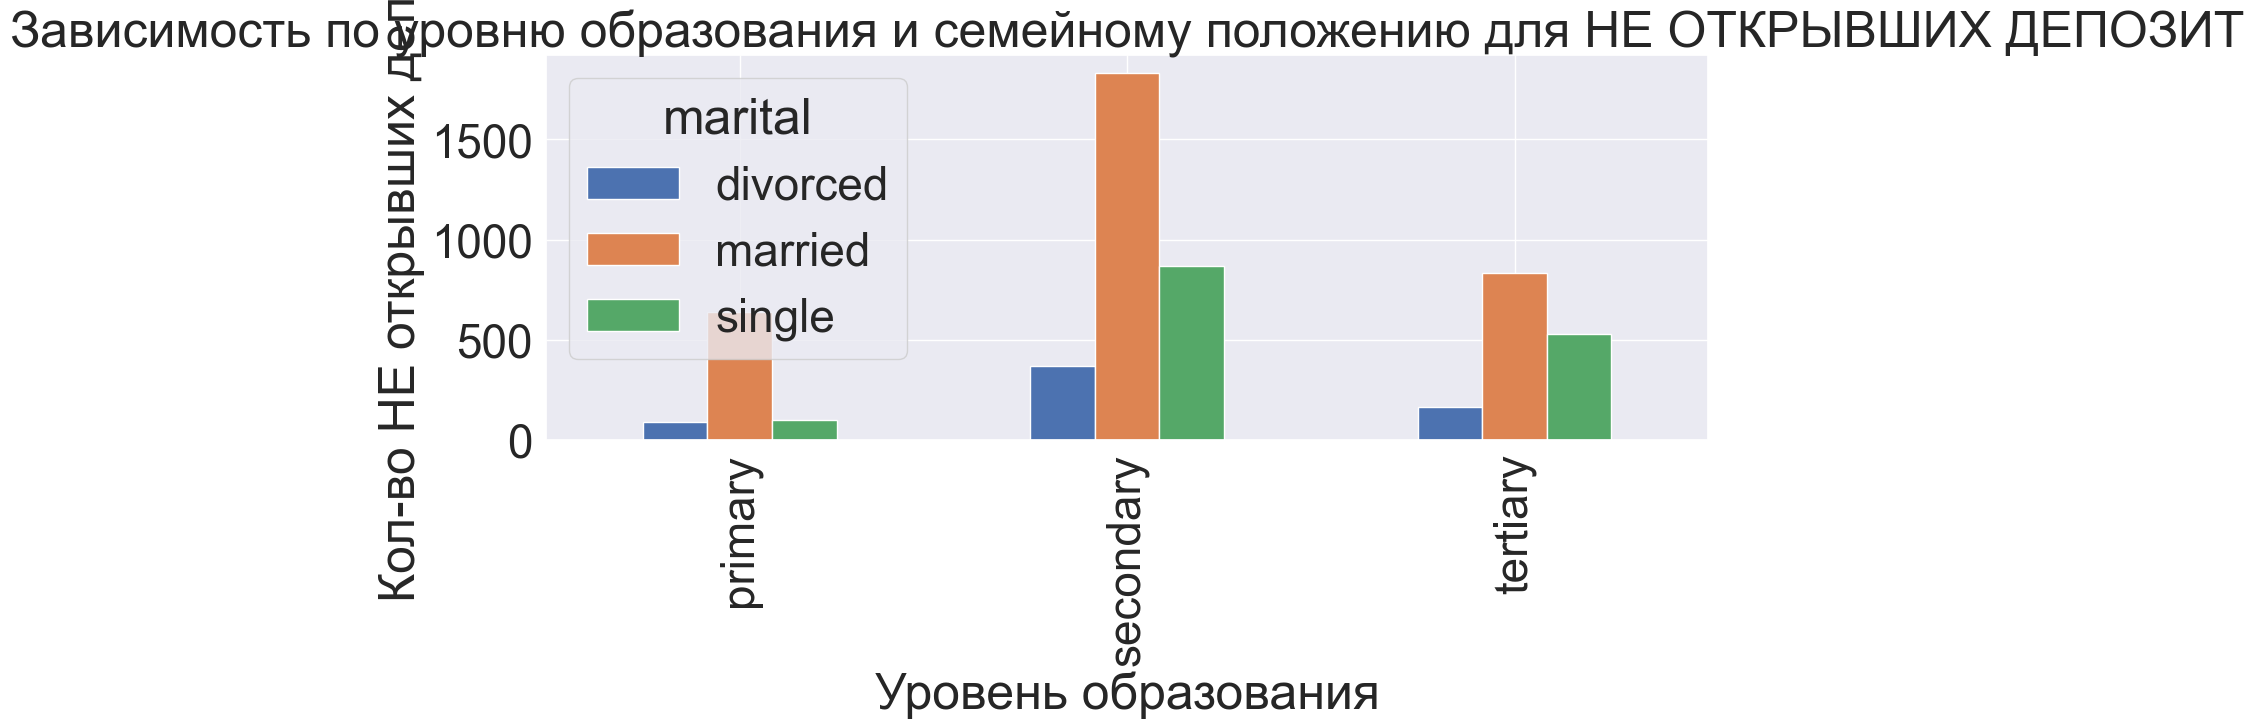

In [500]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
no_deposit = df[df['deposit']==0]

pivot = no_deposit.pivot_table(
    values='deposit',
    index='education',
    columns='marital',
    aggfunc='count',
    fill_value=0
)
fig, axes = plt.subplots(figsize=(15, 5))
pivot.plot(kind='bar', ax=axes)
axes.set_title('Зависимость по уровню образования и семейному положению для НЕ ОТКРЫВШИХ ДЕПОЗИТ')
axes.set_xlabel('Уровень образования')
axes.set_ylabel('Кол-во НЕ открывших депозит');

## Для НЕ открывших депозит: 
* Женатые чаще не берут депозит при всех уровнях образования в отличие от других семейных положений.

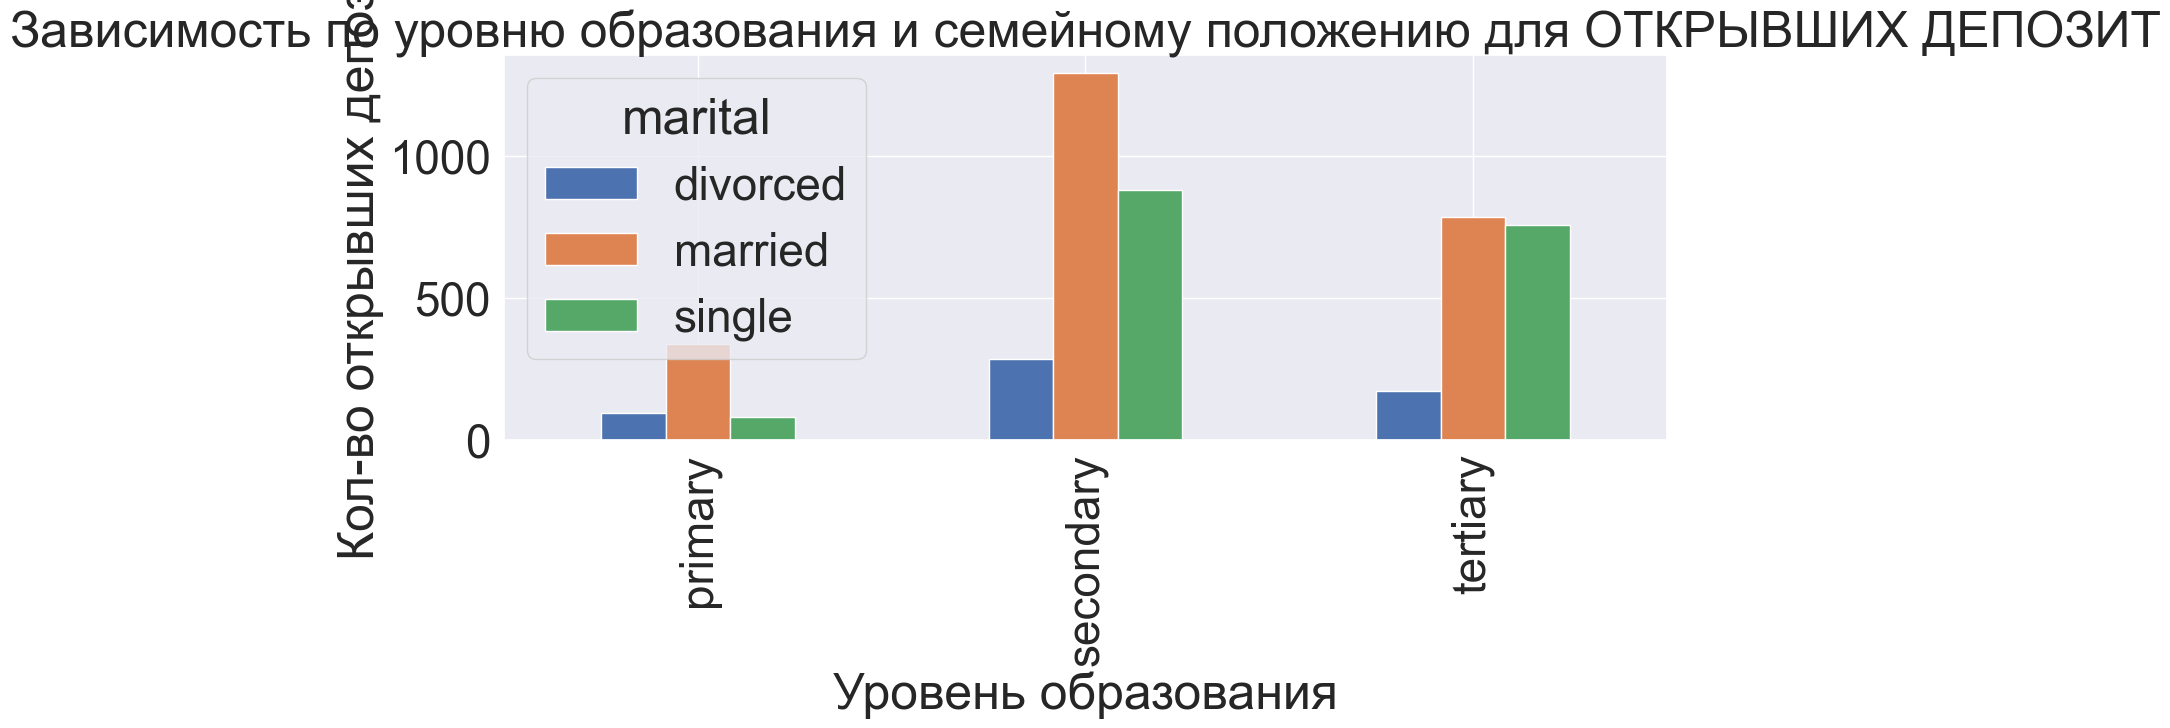

In [501]:
yes_deposit = df[df['deposit']==1]

pivot = yes_deposit.pivot_table(
    values='deposit',
    index='education',
    columns='marital',
    aggfunc='count',
    fill_value=0
)
fig, axes = plt.subplots(figsize=(15, 5))
pivot.plot(kind='bar', ax=axes)
axes.set_title('Зависимость по уровню образования и семейному положению для ОТКРЫВШИХ ДЕПОЗИТ')
axes.set_xlabel('Уровень образования')
axes.set_ylabel('Кол-во открывших депозит');

## Для открывших депозит: 
* Женатые чаще берут депозит чем разведенные и одиночки при primary, secondary уровнем образования.
* При уровне образования tertiary Женатые и Одиночки почти одинаковы по кол-ву депозитов.

## Общая закономерность:
* Разведённые принимают малое участие в принятии решении о депозите для кампании. 
* Самыми активными принимателями решений об открытии депозита являются Женатые люди, на них стоит ориентироваться.


# ИТОГИ EDA:
1. Числовые признаки
    * В данных есть выбросы, от них нужно будет избавиться
    * Нормализация/стандартизация также нужна в большинстве признаков
2. Категориальные признаки:
    * Есть крайне не сбалансированные признаки, от них надо избавиться.
    * Основные предсказательные признаки (предварительно): age, marital, education, month.

## Часть 3: преобразование данных

### Кодировка категориальных признаков (LabelEncoder)

In [502]:
df_coded = df.copy()

In [503]:
lab_enc = LabelEncoder()

df['deposit'] = lab_enc.fit_transform(df['deposit'])

In [504]:
# преобразуйте уровни образования через LabalEncoder
le = LabelEncoder()
le_education = le.fit_transform(df_coded['education'])

df_coded['education'] = le_education
df_coded['education'].sum()

11995

In [505]:
# Закодируем и возрастные группы
le_age = le.fit_transform(df_coded['age'])

df_coded['age'] = le_age

### Кодируем бинарные признаки

In [506]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cols_to_binary = ['default', 'housing', 'loan', 'deposit']

for col in cols_to_binary:
    le = LabelEncoder()
    le = le.fit_transform(df_coded[col])
    df_coded[col] = le

df_coded.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,2,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1
1,2,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1
2,1,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1
3,2,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1
4,2,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1


### Создаём dummy-признаки

In [507]:
# создайте дамми-переменные
columns_to_change = ['job','marital','contact','month','poutcome']
 
for column in columns_to_change:
 print('Число уникальных значений призкака {}: '.format(column), df_coded[column].nunique())

Число уникальных значений призкака job:  11
Число уникальных значений призкака marital:  3
Число уникальных значений призкака contact:  3
Число уникальных значений призкака month:  12
Число уникальных значений призкака poutcome:  4


In [508]:
from sklearn.preprocessing import OneHotEncoder
 
one_hot_encoder = OneHotEncoder()
 
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(df_coded[columns_to_change]).toarray() 
# запишем полученные названия новых колонок в отдельную переменную
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
# создадим датафрейм с индексами и названиями колонок
data_onehot = pd.DataFrame(data=data_onehot, index=df.index, columns=column_names)

In [509]:
# Добавим закодированные столбцы в df_coded
# Соединим таблицы 
df_concated = pd.concat([df_coded, data_onehot], axis=1)

# Удалим columns_to_change
df_concated.drop(columns=columns_to_change, inplace=True)

print(f"Форма полученной таблицы: {df_concated.shape}")

Форма полученной таблицы: (10105, 45)


### Визуализация корреляции в данных

In [510]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
# проверим корреляцию итоговых признаков
def chart_correlation_heatmap(df, 
                              columns, 
                              title, 
                              method='pearson', 
                              correlation_threshold=.6):
    """Построение корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(70, 70))
    correlation_matrix = df[columns].corr(method=method).abs()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix[correlation_matrix.abs() > correlation_threshold], 
                annot=True,
                annot_kws={"fontsize":12}, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='GnBu',
                fmt='.2f')
    ax_.set_title(title, fontsize=24)
    plt.show()

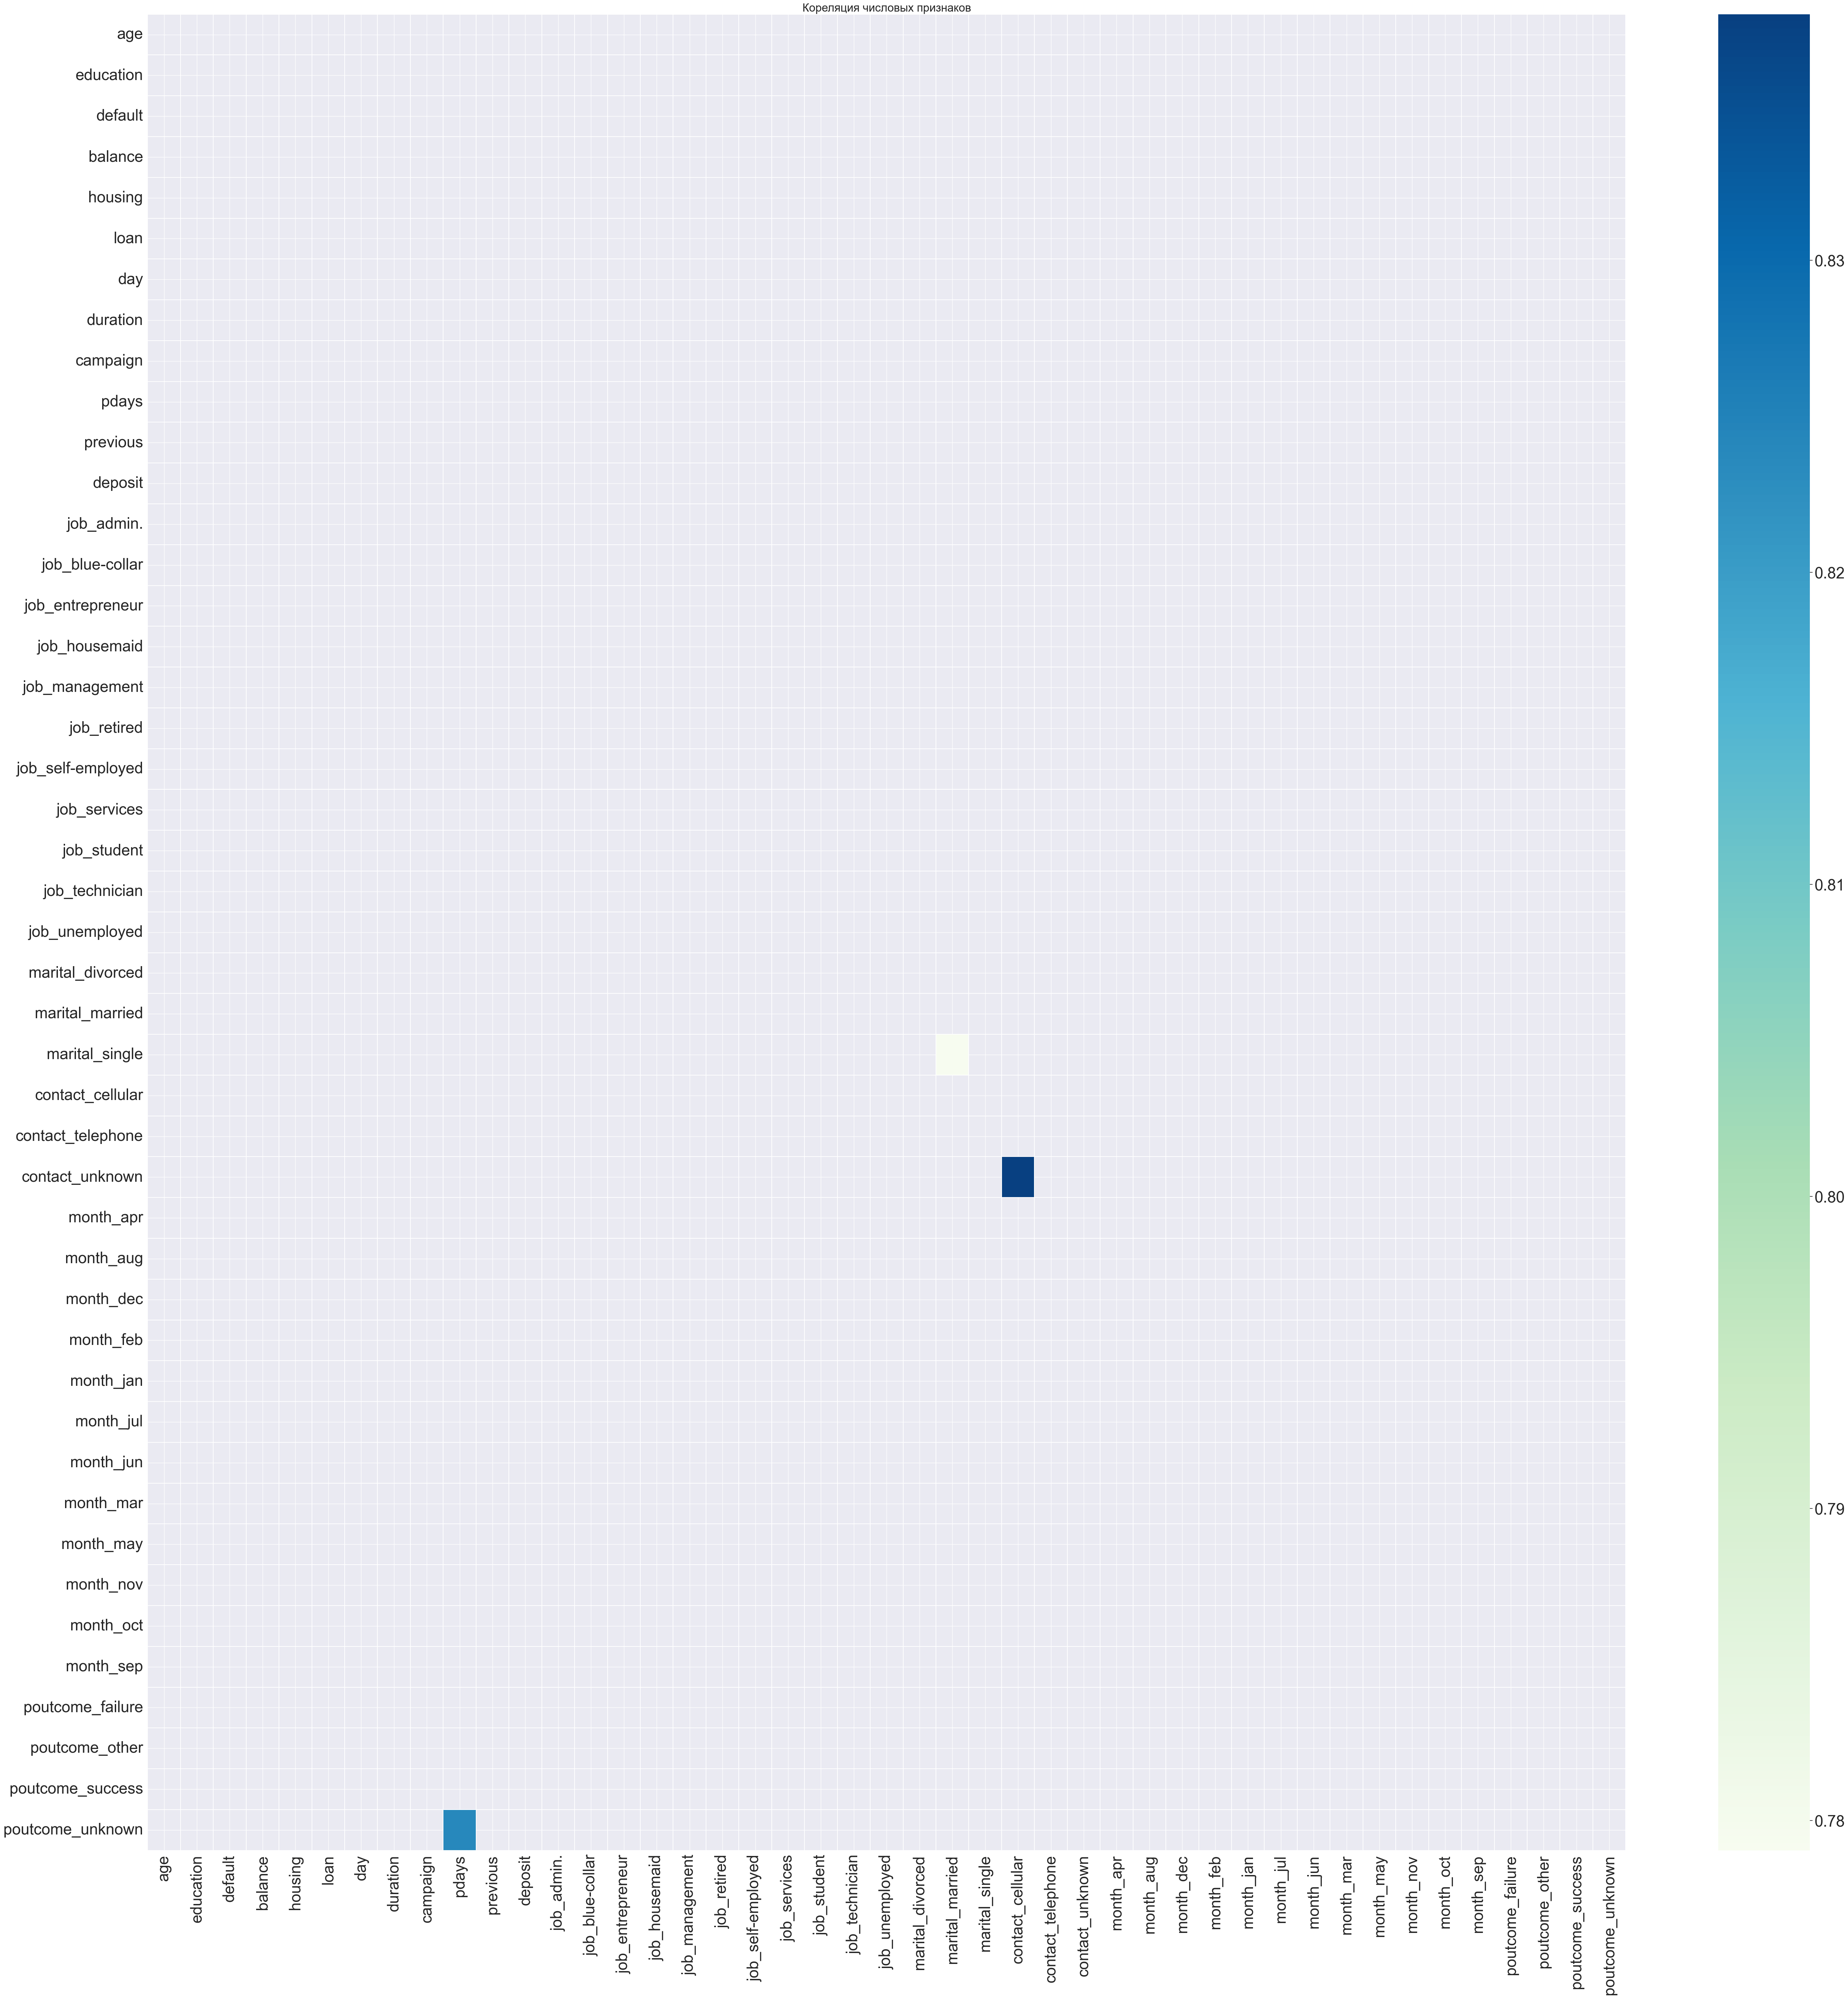

In [511]:
chart_correlation_heatmap(df_concated, 
                          df_concated.columns, 
                          'Кореляция числовых признаков',
                          correlation_threshold = .7)

Корреляция: 
* pdays - poutcome_unknown
* contact_cellular - contact_unknown
* marital_married - marital_single


### Разбиение данных

In [512]:
X = df_concated.drop(['deposit'], axis=1)
y = df_concated['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

## Отбор признаков

In [513]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif # anova

selector = SelectKBest(f_classif, k=15)
selector.fit_transform(X_train, y_train)
 
SKB_cols = selector.get_feature_names_out()

### Нормализация MinMaxScaler

In [514]:
# нормализуйте данные с помощью minmaxscaler
from sklearn.preprocessing import MinMaxScaler


mm_scaler = MinMaxScaler()

mm_scaler.fit(X_train)

X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

In [515]:
# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = mm_scaler.get_feature_names_out()

# Разбиенные train/test выборки в виде df. 
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
df_X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [516]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [517]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))

#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3634
           1       0.85      0.80      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.77      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.81      0.81      3335
weighted avg       0.82      0.82      0.82      3335



### Задания 2,3,4

In [518]:
# обучите решающие деревья, настройте максимальную глубину
#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=6, # максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART без ограничения его глубины
dt_clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [519]:
#Делаем предсказание для тренировочной выборки
y_train_pred = dt_clf.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))

#Делаем предсказание для тестовой выборки
y_test_pred = dt_clf.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      3634
           1       0.78      0.86      0.82      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.80      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [520]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV


param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7],
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [522]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
                n_estimators = 100,
                criterion = 'gini',
                min_samples_leaf = 5,
                max_depth = 10,
                random_state = 42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_test_pred = rf.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1790
           1       0.81      0.85      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335



### Задания 2 и 3

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    # loss='log_loss', #функция потерь
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    min_samples_leaf=5, #минимальное кол-во листов дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_pred_scaled = gb.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred_scaled))

### Задание 4

In [542]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.linear_model import LogisticRegression

In [547]:
# Создаем список кортежей вида: (наименование модели, модель)


from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier


estimators = [
    ('lr', linear_model.LogisticRegression(
        max_iter = 1000, 
        random_state=42, 
        solver='sag')),
    ('dt',  tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42, #генератор случайных чисел
    )),
    ('rf', ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf=5, #list
    random_state=42 #генератор случайных чисел
    ))
]

# Создаем объект класса стекинг
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42, solver='sag')
)
# Обучаем модель
clf.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=5,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [552]:
print(f"accuracy для стекинга: {clf.score(X_test_scaled, y_test)}")

# Формируем предсказание для тестовой выборки
y_pred_stack = clf.predict(X_test_scaled)
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по f1 для стекинга {round(metrics.precision_score(y_test, y_pred_stack), 2)}')

accuracy для стекинга: 0.8389805097451274
Качество предсказания по f1 для стекинга 0.82


2024-05-19 21:28:38,149 - INFO     - Executing shutdown due to inactivity...
2024-05-19 21:28:42,199 - INFO     - Executing shutdown...
2024-05-19 21:28:42,201 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


### Задание 5

### Определим вклад колонок в итоговые признаки, чтобы определить, какие признаки больше влияют на результат

<Axes: >

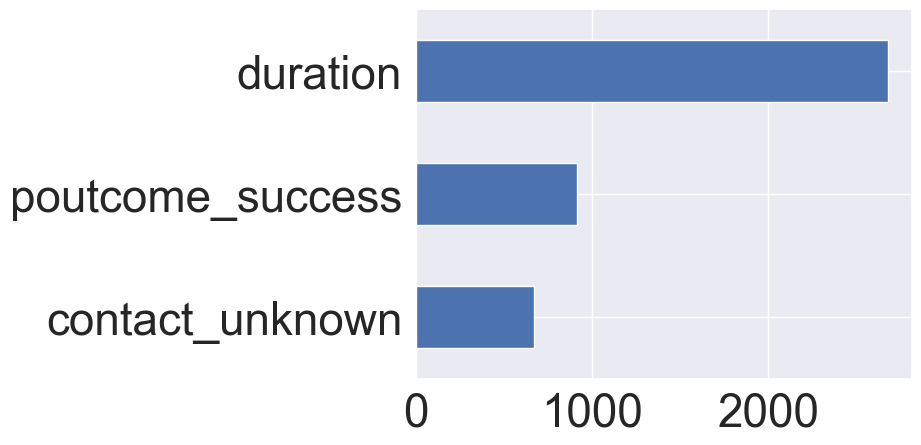

In [563]:
num_cols = ['duration', 'contact_unknown', 'poutcome_success']

# Используем непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает 
# массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)         
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [564]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train_scaled, y_train)

print(f"Индексы 3-x самых важных признаков df: {selector.get_support(indices=True)}")
print(f"3 самых важных признаков df: {df_X_train_scaled.columns[selector.get_support(indices=True)].tolist()}")

Индексы 3-x самых важных признаков df: [ 7 27 42]
3 самых важных признаков df: ['duration', 'contact_unknown', 'poutcome_success']


### Задания 6,7,8

In [566]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

random_state = 42
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [569]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-05-19 22:33:17,981] A new study created in memory with name: RandomForestClassifier
[I 2024-05-19 22:33:19,104] Trial 0 finished with value: 0.8732654949121184 and parameters: {'n_estimators': 188, 'max_depth': 28, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8732654949121184.
[I 2024-05-19 22:33:20,193] Trial 1 finished with value: 0.8985148514851485 and parameters: {'n_estimators': 171, 'max_depth': 21, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8985148514851485.
[I 2024-05-19 22:33:21,506] Trial 2 finished with value: 0.9108726084927672 and parameters: {'n_estimators': 174, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9108726084927672.
[I 2024-05-19 22:33:22,643] Trial 3 finished with value: 0.8832817337461301 and parameters: {'n_estimators': 185, 'max_depth': 15, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9108726084927672.
[I 2024-05-19 22:33:23,474] Trial 4 finished with value: 0.8644779835070795 and parameters: {'n

In [570]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 133, 'max_depth': 20, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.95


In [571]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.84
